## Volatility Features Exploration
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.



In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import ta  # Technical Analysis library for Bollinger Bands, RSI, etc.
from arch import arch_model

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

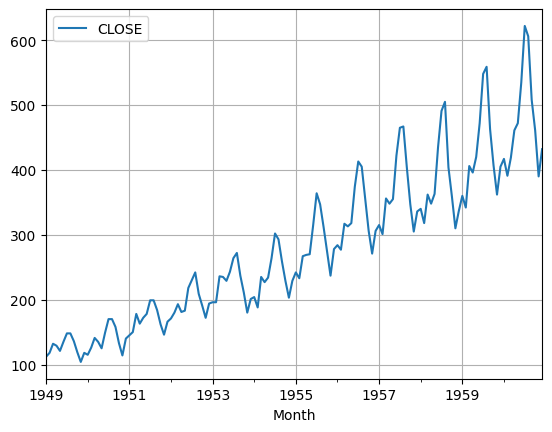

In [27]:
df = pd.read_csv(os.path.join('./data/raw', 'AirPassengers.csv'), parse_dates=["Month"])
df = df.set_index("Month")
df = df.rename(columns={"#Passengers": "CLOSE"})
df.plot()
plt.grid()
plt.show()

## 1.0 Volatility Features

In [28]:
# Calculando os Retornos Logarítmicos
df['Log_Returns'] = np.log(df['CLOSE'] / df['CLOSE'].shift(1))

# Volatilidade Histórica (Desvio Padrão dos Retornos)
df['Historical_Volatility'] = df['Log_Returns'].rolling(window=12).std()
df['MAX_12'] = df['CLOSE'].rolling(window=12, closed='left', min_periods=2).max()
df['MIN_12'] = df['CLOSE'].rolling(window=12, closed='left', min_periods=2).min()
df['AMPLITUDE_12'] = df['MAX_12'] - df['MIN_12']
df['DIFF_AMPLITUDE_12'] = df['AMPLITUDE_12'].diff()
# Média Móvel Exponencial (EMA)
df['EMA_12'] = df['CLOSE'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['CLOSE'].ewm(span=24, adjust=False).mean()

# Desvio Padrão Móvel
df['Rolling_Std'] = df['CLOSE'].rolling(window=12).std()
df['SMA_21'] = df['CLOSE'].rolling(window=12).mean()

# Coeficiente de Variação
df['Coefficient_of_Variation'] = df['Rolling_Std'] / df['SMA_21']
df['Absolute_Returns'] = df['Log_Returns'].abs()
df.dropna(inplace=True)


In [29]:
df.head()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
Month,,,,,,,,,,,,,
1950-01-01,115,-0.025752,0.095370,148.0,104.0,44.0,0.0,122.111849,120.520843,13.453342,126.916667,0.106001,0.025752
1950-02-01,126,0.091350,0.097873,148.0,104.0,44.0,0.0,122.710026,120.959176,13.166475,127.583333,0.103199,0.091350
1950-03-01,141,0.112478,0.097909,148.0,104.0,44.0,0.0,125.523868,122.562442,13.686977,128.333333,0.106652,0.112478
1950-04-01,135,-0.043485,0.098627,148.0,104.0,44.0,0.0,126.981735,123.557446,13.822467,128.833333,0.107290,0.043485
1950-05-01,125,-0.076961,0.099502,148.0,104.0,44.0,0.0,126.676852,123.672851,13.663710,129.166667,0.105784,0.076961


In [34]:
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)

In [35]:
df_scaled.head()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
0,0.001969,0.442296,0.254346,0.0,0.0,0.0,0.350515,0.000000,0.000000,0.004015,0.000000,0.174461,0.115408
1,0.023622,0.704688,0.305327,0.0,0.0,0.0,0.350515,0.001596,0.001292,0.000000,0.001909,0.148945,0.409377
2,0.053150,0.752031,0.306056,0.0,0.0,0.0,0.350515,0.009104,0.006015,0.007285,0.004056,0.180383,0.504061
3,0.041339,0.402562,0.320683,0.0,0.0,0.0,0.350515,0.012993,0.008947,0.009181,0.005488,0.186190,0.194875
4,0.021654,0.327553,0.338515,0.0,0.0,0.0,0.350515,0.012180,0.009287,0.006959,0.006442,0.172478,0.344895


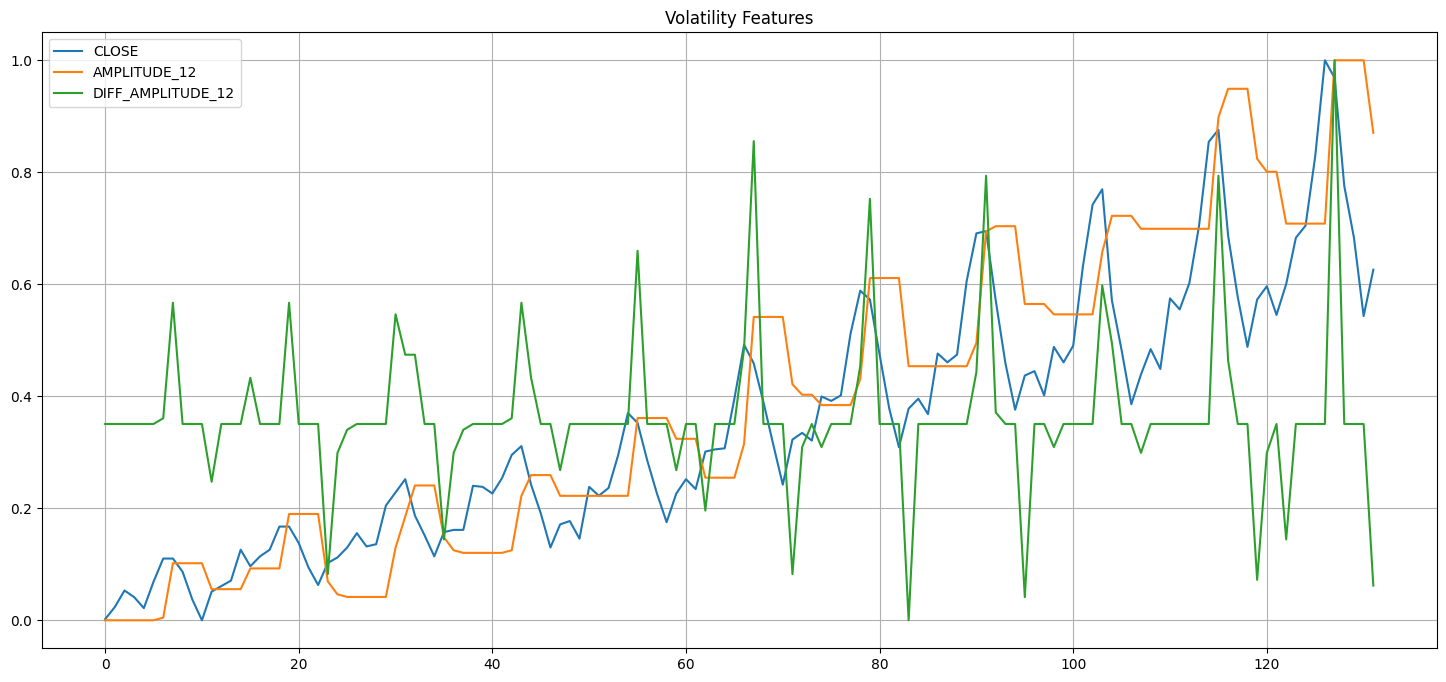

In [36]:
df_scaled[["CLOSE", "AMPLITUDE_12", "DIFF_AMPLITUDE_12"]].plot(figsize=(18, 8)) # "EMA_12", "EMA_26", "SMA_21"
plt.title("Volatility Features")
plt.grid()
plt.show()

In [37]:
df_scaled.corr()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
CLOSE,1.000000,0.099998,0.315724,0.906223,0.907842,0.866940,0.236055,0.936360,0.925451,0.907346,0.917685,0.615841,0.076705
Log_Returns,0.099998,1.000000,-0.010636,-0.097990,0.000934,-0.226897,-0.223824,-0.088029,-0.072310,-0.157804,-0.050583,-0.326159,0.082577
Historical_Volatility,0.315724,-0.010636,1.000000,0.362707,0.312175,0.415751,0.049699,0.343408,0.354230,0.419372,0.338335,0.539848,0.176457
MAX_12,0.906223,-0.097990,0.362707,1.000000,0.987036,0.976470,0.042061,0.994381,0.997648,0.973494,0.995964,0.639203,0.096269
MIN_12,0.907842,0.000934,0.312175,0.987036,1.000000,0.929199,-0.019390,0.981096,0.988994,0.934223,0.994402,0.536679,0.066399
AMPLITUDE_12,0.866940,-0.226897,0.415751,0.976470,0.929199,1.000000,0.122906,0.971511,0.968424,0.986397,0.957279,0.750785,0.132460
DIFF_AMPLITUDE_12,0.236055,-0.223824,0.049699,0.042061,-0.019390,0.122906,1.000000,0.079036,0.046923,0.133098,0.017441,0.320822,-0.273851
EMA_12,0.936360,-0.088029,0.343408,0.994381,0.981096,0.971511,0.079036,1.000000,0.998031,0.978673,0.993644,0.653315,0.112839
EMA_26,0.925451,-0.072310,0.354230,0.997648,0.988994,0.968424,0.046923,0.998031,1.000000,0.972918,0.997852,0.630720,0.105587
Rolling_Std,0.907346,-0.157804,0.419372,0.973494,0.934223,0.986397,0.133098,0.978673,0.972918,1.000000,0.958471,0.779859,0.163556


In [38]:
df.corr()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
CLOSE,1.000000,0.099998,0.315724,0.906223,0.907842,0.866940,0.236055,0.936360,0.925451,0.907346,0.917685,0.615841,0.076705
Log_Returns,0.099998,1.000000,-0.010636,-0.097990,0.000934,-0.226897,-0.223824,-0.088029,-0.072310,-0.157804,-0.050583,-0.326159,0.082577
Historical_Volatility,0.315724,-0.010636,1.000000,0.362707,0.312175,0.415751,0.049699,0.343408,0.354230,0.419372,0.338335,0.539848,0.176457
MAX_12,0.906223,-0.097990,0.362707,1.000000,0.987036,0.976470,0.042061,0.994381,0.997648,0.973494,0.995964,0.639203,0.096269
MIN_12,0.907842,0.000934,0.312175,0.987036,1.000000,0.929199,-0.019390,0.981096,0.988994,0.934223,0.994402,0.536679,0.066399
AMPLITUDE_12,0.866940,-0.226897,0.415751,0.976470,0.929199,1.000000,0.122906,0.971511,0.968424,0.986397,0.957279,0.750785,0.132460
DIFF_AMPLITUDE_12,0.236055,-0.223824,0.049699,0.042061,-0.019390,0.122906,1.000000,0.079036,0.046923,0.133098,0.017441,0.320822,-0.273851
EMA_12,0.936360,-0.088029,0.343408,0.994381,0.981096,0.971511,0.079036,1.000000,0.998031,0.978673,0.993644,0.653315,0.112839
EMA_26,0.925451,-0.072310,0.354230,0.997648,0.988994,0.968424,0.046923,0.998031,1.000000,0.972918,0.997852,0.630720,0.105587
Rolling_Std,0.907346,-0.157804,0.419372,0.973494,0.934223,0.986397,0.133098,0.978673,0.972918,1.000000,0.958471,0.779859,0.163556


## 2.0 Training the models with and without the decomposition features

In [39]:
from src.features.feat_eng import *

In [40]:
def calculate_metrics(pred_df, actuals, predictions):
    logger.debug("Calculating the evaluation metrics...")
    
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
    model_mae = round(mean_absolute_error(actuals, predictions), 2)
    model_wape = round((pred_df.ACTUAL - pred_df.FORECAST).abs().sum() / pred_df.ACTUAL.sum(), 2)

    pred_df["MAPE"] = model_mape
    pred_df["MAE"] = model_mae
    pred_df["WAPE"] = model_wape
    pred_df["RMSE"] = model_rmse

    return pred_df

### 2.2 With Decompose features

In [41]:
TARGET_NAME = "CLOSE"

df_with = df.copy()

FORECAST_HORIZON = 24

train_with = df_with.iloc[:-FORECAST_HORIZON]
test_with = df_with.iloc[-FORECAST_HORIZON:]

In [42]:
train_with = train_with.reset_index()
train_with = train_with.rename(columns={"Month": "DATE"})
train_with = create_date_features(train_with)
train_with = train_with.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
# train_with["Volatility"] = train_with[TARGET_NAME].rolling(window=3, closed='left', min_periods=1).std()
train_with.dropna(inplace=True)
X_train = train_with.drop(columns=[TARGET_NAME])
y_train = train_with[TARGET_NAME]
# train_with = train_with.set_index("Month")

test_with = test_with.reset_index()
test_with = test_with.rename(columns={"Month": "DATE"})
test_with = create_date_features(test_with)
test_with = test_with.drop(columns=["DAY_OF_MONTH", "DAY_OF_WEEK", "WEEK_OF_MONTH"])
X_test = test_with.drop(columns=[TARGET_NAME])
y_test = test_with[TARGET_NAME]
# test_with = test_with.set_index("Month")

In [43]:
X_train

,DATE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns,MONTH,QUARTER,YEAR
0,1950-01-01,-0.025752,0.095370,148.0,104.0,44.0,0.0,122.111849,120.520843,13.453342,126.916667,0.106001,0.025752,1,1,1950
1,1950-02-01,0.091350,0.097873,148.0,104.0,44.0,0.0,122.710026,120.959176,13.166475,127.583333,0.103199,0.091350,2,1,1950
2,1950-03-01,0.112478,0.097909,148.0,104.0,44.0,0.0,125.523868,122.562442,13.686977,128.333333,0.106652,0.112478,3,1,1950
3,1950-04-01,-0.043485,0.098627,148.0,104.0,44.0,0.0,126.981735,123.557446,13.822467,128.833333,0.107290,0.043485,4,2,1950
4,1950-05-01,-0.076961,0.099502,148.0,104.0,44.0,0.0,126.676852,123.672851,13.663710,129.166667,0.105784,0.076961,5,2,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1958-08-01,0.028114,0.113849,491.0,305.0,186.0,24.0,404.249730,375.921799,65.557054,379.500000,0.172746,0.028114,8,3,1958
104,1958-09-01,-0.223144,0.125002,505.0,305.0,200.0,14.0,404.211310,378.168055,65.557054,379.500000,0.172746,0.223144,9,3,1958
105,1958-10-01,-0.118092,0.121580,505.0,305.0,200.0,0.0,397.255724,376.634611,65.106207,380.500000,0.171107,0.118092,10,4,1958
106,1958-11-01,-0.146750,0.123422,505.0,305.0,200.0,0.0,383.831767,371.303842,64.593074,380.916667,0.169573,0.146750,11,4,1958


In [44]:
model = train_model(X_train.drop(columns=["DATE"]), y_train, 'XGB', 'Seasonal', load_best_params=False)

[0]	validation_0-rmse:66.97253	validation_0-logloss:-10957.49098
[20]	validation_0-rmse:0.93925	validation_0-logloss:-10966.51722
[40]	validation_0-rmse:0.10333	validation_0-logloss:-10966.55151
[60]	validation_0-rmse:0.01312	validation_0-logloss:-10966.55280
[80]	validation_0-rmse:0.00156	validation_0-logloss:-10966.55283
[99]	validation_0-rmse:0.00097	validation_0-logloss:-10966.55284


In [45]:
predictions = model.predict(X_test.drop(columns=["DATE"]))
train_predictions = model.predict(X_train.drop(columns=["DATE"]))

In [46]:
pred_df = test_with.copy()
train_pred_df = train_with.copy()

In [47]:
pred_df = pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
pred_df["FORECAST"] = predictions

train_pred_df = train_pred_df.rename(columns={TARGET_NAME: "ACTUAL"})
train_pred_df["FORECAST"] = train_predictions

In [48]:
pred_df = calculate_metrics(pred_df, test_with[TARGET_NAME], predictions)
train_pred_df = calculate_metrics(train_pred_df, train_with[TARGET_NAME], train_predictions)

In [49]:
pred_df.head()

,DATE,ACTUAL,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,...,Coefficient_of_Variation,Absolute_Returns,MONTH,QUARTER,YEAR,FORECAST,MAPE,MAE,WAPE,RMSE
0,1959-01-01,360,0.066021,0.124000,505.0,310.0,195.0,0.0,374.068898,367.874772,...,0.166273,0.066021,1,1,1959,348.020599,0.106,51.89,0.11,65.82
1,1959-02-01,342,-0.051293,0.123260,505.0,310.0,195.0,0.0,369.135221,365.804790,...,0.160553,0.051293,2,1,1959,335.979706,0.106,51.89,0.11,65.82
2,1959-03-01,406,0.171542,0.127600,505.0,310.0,195.0,0.0,374.806726,369.020407,...,0.158620,0.171542,3,1,1959,353.365234,0.106,51.89,0.11,65.82
3,1959-04-01,396,-0.024939,0.127162,505.0,310.0,195.0,0.0,378.067230,371.178774,...,0.153657,0.024939,4,2,1959,349.384125,0.106,51.89,0.11,65.82
4,1959-05-01,420,0.058841,0.127626,505.0,310.0,195.0,0.0,384.518425,375.084472,...,0.151123,0.058841,5,2,1959,354.943573,0.106,51.89,0.11,65.82


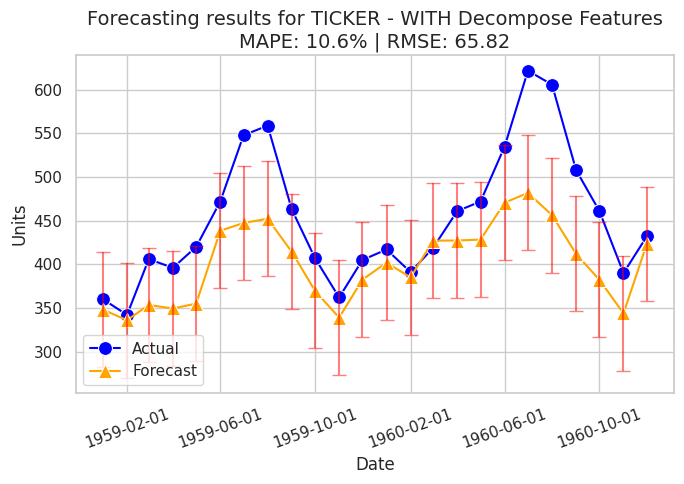

In [50]:
visualize_validation_results(pred_df, "WITH Decompose Features")

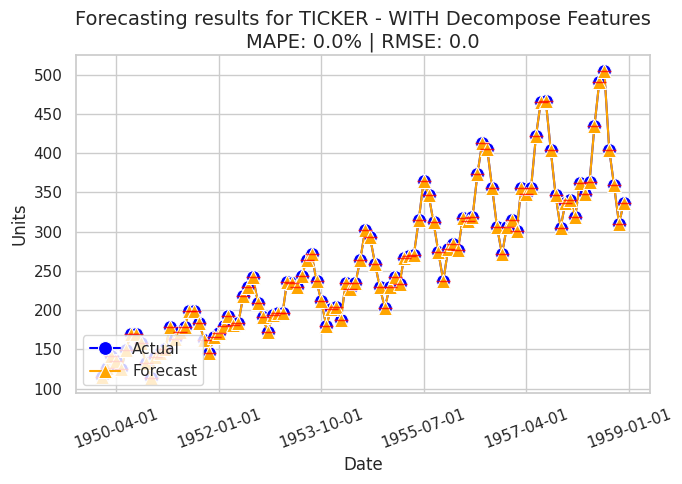

In [63]:
visualize_validation_results(train_pred_df, "WITH Decompose Features")